<a href="https://colab.research.google.com/github/hardeybisey/Dog_Cat_Image_Classification/blob/main/dog-cat-classification-with-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! kaggle competitions download dogs-vs-cats #download data with kaggle api

100% 812M/812M [00:36<00:00, 25.5MB/s]
100% 812M/812M [00:36<00:00, 23.5MB/s]


**Importing libraries**

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from zipfile import ZipFile
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization,\
RandomFlip , RandomRotation
from tensorflow.keras.utils import to_categorical
import datetime
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
print("TF version:", tf.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available!")

TF version: 2.9.2
GPU available (YESS!!!!)


**Unzip the training and test data and store them in  `tmp` folder**

In [17]:
def extract_files(dir):
    ''' This function extracts files in the given dir  '''
    with ZipFile(dir,'r') as zip:
        zip.extractall()
        zip.close()
    print('Extracting files ...')

In [14]:
full = '/content/dogs-vs-cats.zip'
extract_files(full)
extract_test = '/content/test1.zip'
extract_files(extract_test)
extract_train = '/content/train.zip'
extract_files(extract_train)

Extracting files ...
Extracting files ...
Extracting files ...


**confirm how many images are in the training set**

In [18]:
train_dir = '/content/train/'
print(f"There are {len(os.listdir(train_dir))} images of dogs and cats.")

There are 25000 images of dogs and cats.


**Store the paths in a list and assign labels to each image**

In [19]:
def label_image(folder_path):
  file_names = []
  labels = []
  for subdir, dirs, files in os.walk(folder_path):
      for file in files:
          filepath = subdir + file
          if filepath.endswith(".jpg"):
              file_names.append(filepath)
              if file[:3]=='dog':
                  labels.append('dog')
              else:
                  labels.append('cat')
  return file_names , labels

In [20]:
train_path , train_labels = label_image(train_dir)

# validate the output of the function

In [26]:
train_path[:5] , train_labels[:5]

(['/content/train/cat.4543.jpg',
  '/content/train/dog.4119.jpg',
  '/content/train/dog.7103.jpg',
  '/content/train/dog.10484.jpg',
  '/content/train/cat.11064.jpg'],
 ['cat', 'dog', 'dog', 'dog', 'cat'])

In [27]:
unique_labels = np.unique(train_labels)
model_label = LabelEncoder().fit_transform(train_labels)
model_label = to_categorical(model_label)

**confirm we have the same number of labels and files**

In [28]:
print(f'There are {len(train_path)} file Paths')
print(f'There are {len(train_labels)} Labels') 

There are 25000 file Paths
There are 25000 Labels


# **Create Functions to organize the pipeline of the model**

In [59]:
def process_image(image_path=None,img_size=240,channels=3):
  """
  Takes an image file path and returns the tensor of the resized image 
  """
  image = tf.io.read_file(image_path) 
  # turn the jpg image into numerical tensors
  image = tf.image.decode_jpeg(image,channels) 
  # convert  the colour channel values from 0-255 to 0 -1 (normalization)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image,size=[img_size,img_size])

  return image

In [55]:
def get_image_label(image_path,label):
  """
  Takes an image path with label 
  returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image , label

In [56]:
def process_data(X,y=None,val_data=False,test_data=False,augument=False,batch_size=32):
  """
  if val_data: returns a resized image and label tuple in the form of a tensor with the specified batch size.
  if test_data: returns a resized image in the form of a tensor with the specified batch size.
  if train_data: returns a resized and augumented image with labels tuple in the form of a tensor with the specified batch size.
  """
  AUTOTUNE = tf.data.AUTOTUNE
  # set up image augmentation 
  data_augmentation = Sequential([RandomFlip("horizontal_and_vertical"),RandomRotation(0.1)])

  if test_data: # no labels required
    print('creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
    data = data.map(process_image)
    data_batch = data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return data_batch
  
  if val_data: 
    print('creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data = data.map(get_image_label)
    data_batch = data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return data_batch
  
  else:
    print('creating training data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    if augument:
        data = data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    data_batch = data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return data_batch

In [57]:
def show_images(images,labels,num=None,nrows=None,ncols=None):
    """ Displays a plot of n images and thier labels from a data batch """
    # set up the figure
    plt.figure(figsize=(10,10))
    #loop through
    for i in range(num):
      ax = plt.subplot(nrows,ncols,i+1)
      plt.imshow(images[i])
      plt.title(unique_labels[np.argmax(labels[i])])
      plt.axis('off')
    plt.tight_layout()
    plt.show()

In [38]:
def save_model(model,suffix=None):
    """
    Saves a given model in a models directory and append a suffix (string)
    """
    modeldir = os.path.join('/models', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = modeldir + '_' + '.h5'  #save format of a model
    model.save(model_path)
    
    return model_path

In [39]:
def load_model(model_path):
  """
  Loads a model from the specified path
  """
  print(f"Loading model from: {model_path}...")
  model = tf.keras.models.load_model(model_path)

  return model

In [40]:
def get_pred_label(prediction_prob):
  """
  Turns an array of prediction probabilities into a label 
  """
  return unique_labels[np.argmax(prediction_prob)]

In [41]:
def plot_pred(prediction_prob,labels,images, num=0,nrows=None,ncols=None):
  """
  View the prediction ground truth and images for sample n
  """
  # Create a Figure
  plt.figure(figsize=(5*ncols,3*nrows))
  for i in range(num):
      pred_prob , true_label , image = prediction_prob[i] , labels[i] , images[i]
      # get the pred label
      pred_label = get_pred_label(pred_prob)
      ax = plt.subplot(nrows,ncols,i+1)
      # change the color of the title depending on the prediction
      if pred_label == true_label:
        color = 'green' # True Prediction
      else:
        color = 'red' # Wrong Prediction
      # change plot title to be predicted class and probability
      plt.title((f"This image is {np.max(pred_prob)*100:2.0f}% {pred_label}"),
                color = color, fontweight='bold', fontsize=15)
      plt.imshow(image)
      plt.axis('off')
  plt.tight_layout()
  plt.show()

In [42]:
def unbatch_data(batch_data,test=False):
  """ Takes a bacthed dataset of (image,label) Tensors and returns separate arrays of """
  if test:  
      images = []
      for image in batch_data.unbatch().as_numpy_iterator():
        images.append(image)
      return images
  else:
      images = []
      labels = []
      for image , label in batch_data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_labels[np.argmax(label)])
      return images , labels

In [43]:
def model_diagnostic_plot(history,loss=False,accuracy=False):
    if loss:# plot loss
        plt.figure(figsize=(10,5))
        plt.subplot(211)
        plt.title('Training and validation Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')
        plt.legend()
        plt.show()
    if accuracy: # plot accuracy
        plt.figure(figsize=(10,5))
        plt.subplot(212)
        plt.title('Training and validation Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
        plt.legend()
        plt.show()

# **Split the data into train and validation set**

In [44]:
X = train_path
y = model_label
X_train , X_val , Y_train , Y_val = train_test_split(X, y, random_state=42, test_size=0.15)

# **Create a train and validation batch**

In [60]:
train_data = process_data(X=X_train, y=Y_train,augument=True)
val_data = process_data(X=X_val, y=Y_val, val_data=True)

creating training data batches...
creating validation data batches...


**visualize a subject of the training data**

In [61]:
train_images , train_labels = next(train_data.as_numpy_iterator())

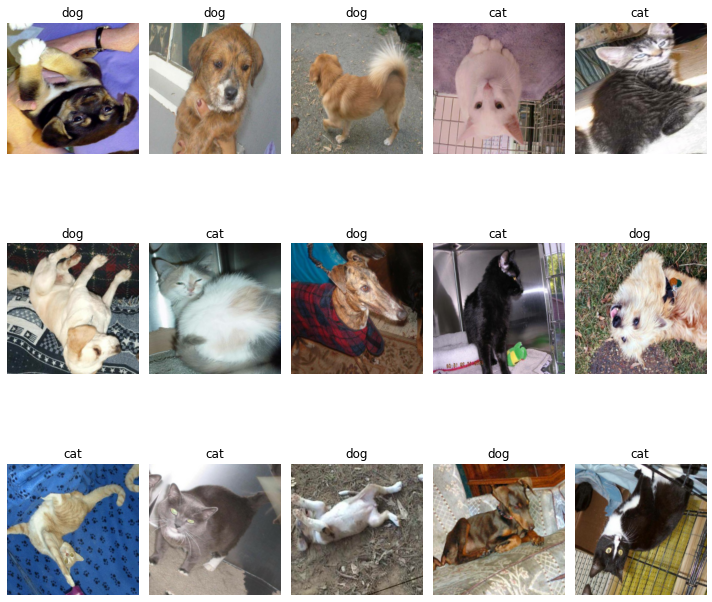

In [62]:
show_images(train_images[:15],train_labels[:15],num=15,nrows=3,ncols=5)

# **Setup the network**

In [52]:
def make_model(img_size=None,output_shape=None):

    INPUT_SHAPE = (img_size,img_size,3)
    model = Sequential()
    model.add(Input(shape= INPUT_SHAPE,name ='input'))
    model.add(Conv2D(filters=32,kernel_size=[5,5],activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64,kernel_size=[5,5],activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.4))
    
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(output_shape,activation='sigmoid'))
    
    return model

In [53]:
IMG_SIZE = 240
OUTPUT_SHAPE = len(unique_labels)
model = make_model(img_size=IMG_SIZE,output_shape=OUTPUT_SHAPE)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 236, 236, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 236, 236, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 118, 118, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 114, 114, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 114, 114, 64)    

In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create a Tensorboard session
# tensorbaord = create_tensorboard_callback()
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
# fit the model to the data and pass it the callbacks
batch_size = 32
history = model.fit(x=train_data,
                    validation_data=val_data, 
                    epochs=20) #callbacks = [tensorbaord,early_stopping]

Epoch 1/20
665/665 [==============================] - 172s 245ms/step - loss: 0.7586 - accuracy: 0.5720 - val_loss: 1.0093 - val_accuracy: 0.4979
Epoch 2/20
665/665 [==============================] - 162s 244ms/step - loss: 0.6304 - accuracy: 0.6496 - val_loss: 0.6643 - val_accuracy: 0.5805
Epoch 3/20
665/665 [==============================] - 162s 243ms/step - loss: 0.5894 - accuracy: 0.6862 - val_loss: 0.5647 - val_accuracy: 0.7000
Epoch 4/20
665/665 [==============================] - 163s 245ms/step - loss: 0.5607 - accuracy: 0.7095 - val_loss: 0.5517 - val_accuracy: 0.6979
Epoch 5/20
665/665 [==============================] - 166s 250ms/step - loss: 0.5351 - accuracy: 0.7319 - val_loss: 0.5917 - val_accuracy: 0.6680
Epoch 6/20
665/665 [==============================] - 164s 246ms/step - loss: 0.5135 - accuracy: 0.7483 - val_loss: 0.5402 - val_accuracy: 0.7104
Epoch 7/20
665/665 [==============================] - 162s 244ms/step - loss: 0.4952 - accuracy: 0.7613 - val_loss: 0.4758 -

In [64]:
# save model
save_path = save_model(model)

In [65]:
# load model
loaded_model = load_model(save_path)

Loading model from: /models/20230103-213416_.h5...


# **Model diagnostics plot**

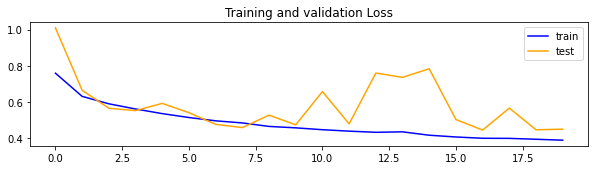

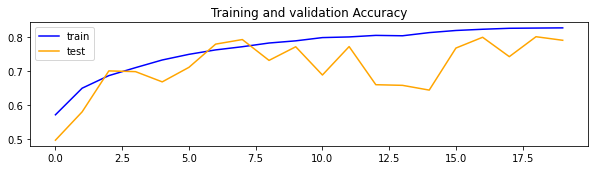

In [66]:
model_diagnostic_plot(history,loss=True, accuracy=True)

In [68]:
val_pred = loaded_model.predict(val_data)

118/118 [==============================] - 11s 91ms/step


**plot the predicted image and the probability of model on validation data**

In [69]:
val_images , val_labels = unbatch_data(val_data)

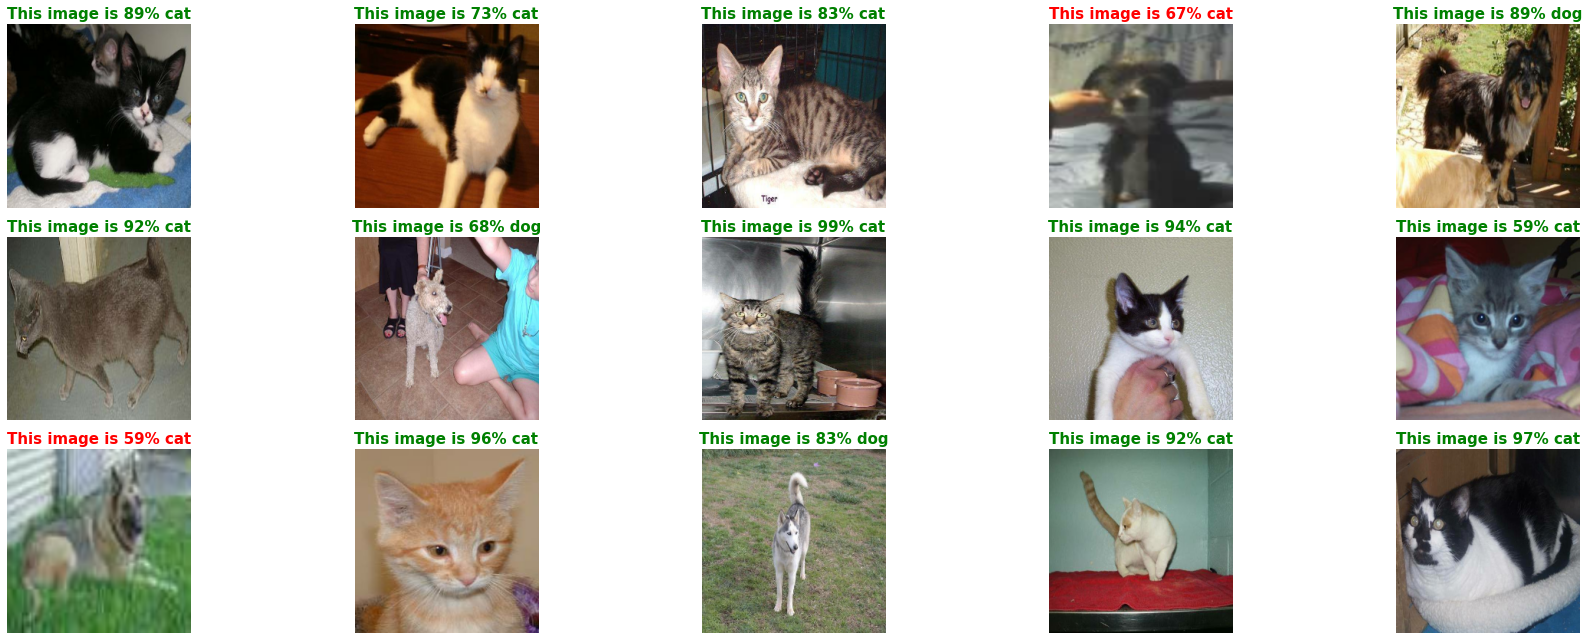

In [71]:
plot_pred(prediction_prob=val_pred,labels= val_labels,images=val_images,num=15,nrows=3,ncols=5)

# **Loading the test data**

In [74]:
test_path = '/content/test1/'
test_dir = []
for subdir, dirs, files in os.walk(test_path):
    for file in files:
        filepath = subdir + file
        if filepath.endswith(".jpg"):
            test_dir.append(filepath)

**processing the test data with the process_data function**

In [75]:
test_data = process_data(X=test_dir, test_data=True)

creating test data batches...


**making predictions on the test data**

In [76]:
test_pred = loaded_model.predict(test_data)

391/391 [==============================] - 26s 66ms/step


**Submission**

In [149]:
df = pd.read_csv('../content/sample_submission.csv')
label = [get_pred_label((i,x)) for i,x in test_pred]
df['label'] = label
df['label'] = df['label'].map({'cat': 0, 'dog': 1})
df.head()

,id,label
0,1,1
1,2,1
2,3,0
3,4,1
4,5,1


In [152]:
df.to_csv('/content/submission.csv',index=False)

**TensorBoard and early stopping callback to track models progress**


In [ ]:
def create_tensorboard_callback():
  # create a log directory for storing tensorboard logs
  logdir = os.path.join('logs/',
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)